<a href="https://colab.research.google.com/github/VitorZ-Pamplona/Projeto-PDI-Arcada-Dentaria/blob/main/Projeto_AD_PDI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bibliotecas

In [116]:
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [117]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [118]:
path_canal = "/content/drive/MyDrive/DENTES SEPARADOS/CANAL"
path_saudavel = "/content/drive/MyDrive/DENTES SEPARADOS/SAUDAVEL"

images_canal = []
images_saudavel = []

for filename in os.listdir(path_canal):
  img_path = os.path.join(path_canal, filename)
  image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
  images_canal.append(image)

for filename in os.listdir(path_saudavel):
  img_path = os.path.join(path_saudavel, filename)
  image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
  images_saudavel.append(image)

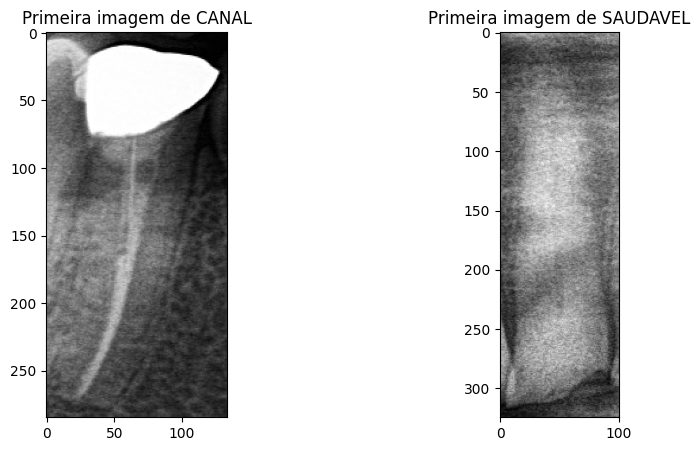

In [120]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
if images_canal:
    plt.imshow(images_canal[4], cmap='gray')
    plt.title("Primeira imagem de CANAL")
plt.subplot(1, 2, 2)
if images_saudavel:
    plt.imshow(images_saudavel[0], cmap='gray')
    plt.title("Primeira imagem de SAUDAVEL")
plt.show()

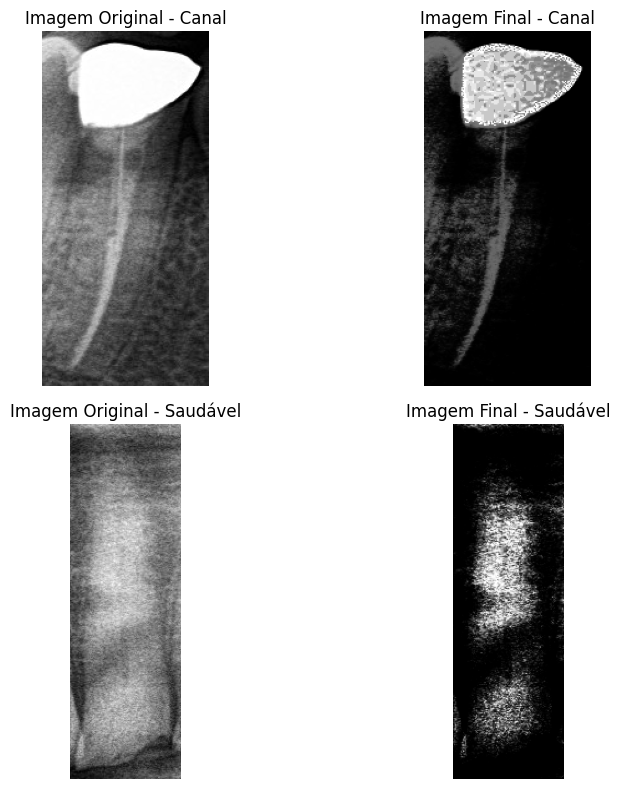

In [121]:
def enhance_contrast(image):
    # Aplicar CLAHE
    clahe = cv2.createCLAHE(clipLimit=4, tileGridSize=(1, 1))
    image = clahe.apply(image)

    # Equalização de Histograma
    image = cv2.equalizeHist(image)

    # Ajuste de Gama
    gamma = 6
    image = np.array(255*(image / 255) ** gamma, dtype='uint8')

    return image

final_image_canal = enhance_contrast(images_canal[4])
final_image_saudavel = enhance_contrast(images_saudavel[0])

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# Imagem original - Canal
axes[0, 0].imshow(images_canal[4], cmap='gray')
axes[0, 0].set_title("Imagem Original - Canal")
axes[0, 0].axis('off')  # Desativa a visualização dos eixos

# Imagem final - Canal
axes[0, 1].imshow(final_image_canal, cmap='gray')
axes[0, 1].set_title("Imagem Final - Canal")
axes[0, 1].axis('off')

# Imagem original - Saudável
axes[1, 0].imshow(images_saudavel[0], cmap='gray')
axes[1, 0].set_title("Imagem Original - Saudável")
axes[1, 0].axis('off')

# Imagem final - Saudável
axes[1, 1].imshow(final_image_saudavel, cmap='gray')
axes[1, 1].set_title("Imagem Final - Saudável")
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

# Rede


## Aplica o Filtro para todas as Imagens

In [122]:
images_saudavel_contrast = [enhance_contrast(image) for image in images_saudavel]
images_canal_contrast = [enhance_contrast(image) for image in images_canal]

In [123]:
len(images_saudavel_contrast)

227

In [124]:
images_saudavel_contrast = images_saudavel_contrast[127:]
len(images_saudavel_contrast)

100

In [125]:
len(images_canal_contrast)

54

## Ajusta o tamanho de todas as imagens

In [126]:
def resize_images(image_list, size=(64, 64)):
    resized_images = [cv2.resize(img, size, interpolation=cv2.INTER_AREA) for img in image_list]
    return resized_images

images_saudavel_contrast = resize_images(images_saudavel_contrast)
images_canal_contrast = resize_images(images_canal_contrast)

## Construção dos dados de treinamento e validação

In [127]:
labels_saudavel = [0] * len(images_saudavel_contrast)
labels_canal = [1] * len(images_canal_contrast)

images = images_saudavel_contrast + images_canal_contrast
labels = labels_saudavel + labels_canal

images = np.array(images)
labels = np.array(labels)

indices = np.arange(images.shape[0])
np.random.shuffle(indices)
images = images[indices]
labels = labels[indices]

## Construção do Modelo

In [128]:
def build_model(input_shape):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Configuração do tamanho da entrada
input_shape = (64, 64, 1)

model = build_model(input_shape)
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 62, 62, 32)        320       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 31, 31, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 14, 14, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 6, 6, 128)        

## Divisão de Treino e Validação

In [129]:
images_train, images_val, labels_train, labels_val = train_test_split(
    images, labels, test_size=0.2, random_state=42
)

## Adiciona uma camada de dimensão para que o data augmentation funcione com tons de cinza

In [130]:
def add_channel_dimension(image_list):
    return np.expand_dims(image_list, axis=-1)

images_train = add_channel_dimension(images_train)
images_val = add_channel_dimension(images_val)

print("Dimensão das imagens de treinamento:", images_train.shape)
print("Dimensão das imagens de validação:", images_val.shape)

Dimensão das imagens de treinamento: (123, 64, 64, 1)
Dimensão das imagens de validação: (31, 64, 64, 1)


In [131]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(
    images_train, labels_train,
    batch_size=32
)

validation_generator = test_datagen.flow(
    images_val, labels_val,
    batch_size=32
)

In [132]:
history = model.fit(
    train_generator,
    steps_per_epoch=max(1, len(images_train) // 32),
    epochs=50,
    validation_data=validation_generator,
    validation_steps=max(1, len(images_val) // 32)
)

Epoch 1/50
3/3 [==============================] - 2s 111ms/step - loss: 0.6873 - accuracy: 0.5275 - val_loss: 0.6136 - val_accuracy: 0.7097
Epoch 2/50
3/3 [==============================] - 0s 42ms/step - loss: 0.6190 - accuracy: 0.6923 - val_loss: 0.6432 - val_accuracy: 0.7097
Epoch 3/50
3/3 [==============================] - 0s 42ms/step - loss: 0.6067 - accuracy: 0.7083 - val_loss: 0.6475 - val_accuracy: 0.7097
Epoch 4/50
3/3 [==============================] - 0s 39ms/step - loss: 0.6391 - accuracy: 0.6813 - val_loss: 0.6602 - val_accuracy: 0.7097
Epoch 5/50
3/3 [==============================] - 0s 40ms/step - loss: 0.6623 - accuracy: 0.7083 - val_loss: 0.6606 - val_accuracy: 0.7097
Epoch 6/50
3/3 [==============================] - 0s 45ms/step - loss: 0.6333 - accuracy: 0.7083 - val_loss: 0.6201 - val_accuracy: 0.7419
Epoch 7/50
3/3 [==============================] - 0s 41ms/step - loss: 0.6232 - accuracy: 0.6484 - val_loss: 0.6186 - val_accuracy: 0.7097
Epoch 8/50
3/3 [==========

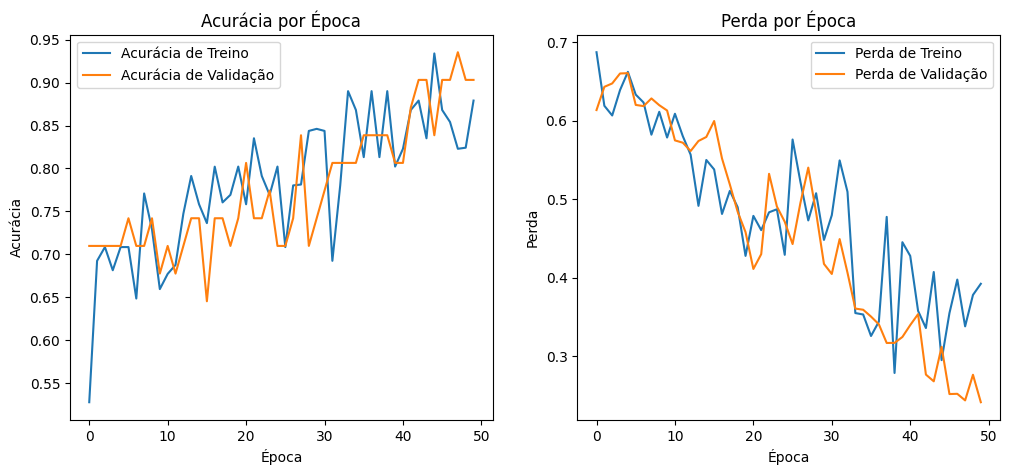

In [133]:
# Acurácia
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)  # Primeiro gráfico em uma grade 1x2
plt.plot(history.history['accuracy'], label='Acurácia de Treino')
plt.plot(history.history['val_accuracy'], label='Acurácia de Validação')
plt.title('Acurácia por Época')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()

# Perda
plt.subplot(1, 2, 2)  # Segundo gráfico na mesma linha
plt.plot(history.history['loss'], label='Perda de Treino')
plt.plot(history.history['val_loss'], label='Perda de Validação')
plt.title('Perda por Época')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend()

plt.show()

In [134]:
# Supondo que você tem `images_test` e `labels_test` para testar o modelo
predictions = model.predict(images_val)
predictions = (predictions > 0.5).astype(int)  # Convertendo probabilidades em classificações binárias

# Calculando métricas
accuracy = accuracy_score(labels_val, predictions)
precision = precision_score(labels_val, predictions)
recall = recall_score(labels_val, predictions)
f1 = f1_score(labels_val, predictions)

print(f"Acurácia: {accuracy:.2f}")
print(f"Precisão: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

1/1 [==============================] - 0s 122ms/step
Acurácia: 0.87
Precisão: 0.69
Recall: 1.00
F1-Score: 0.82


In [145]:
# Caminhos para as imagens
image_path1 = '/content/Dente com Canal.png'
image_path2 = '/content/dente Saudavel.png'

# Carregar imagens em escala de cinza
image1 = cv2.imread(image_path1, cv2.IMREAD_GRAYSCALE)
image2 = cv2.imread(image_path2, cv2.IMREAD_GRAYSCALE)

image1 = enhance_contrast(image1)
image2 = enhance_contrast(image2)

# Preparar imagens (redimensionar, adicionar canal, normalizar)
image1_prepared = cv2.resize(image1, (64, 64), interpolation=cv2.INTER_AREA).reshape(1, 64, 64, 1) / 255.0
image2_prepared = cv2.resize(image2, (64, 64), interpolation=cv2.INTER_AREA).reshape(1, 64, 64, 1) / 255.0

1/1 [==============================] - 0s 30ms/step


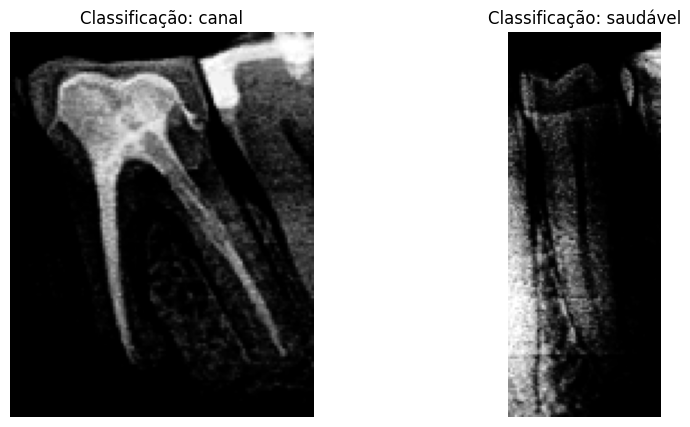

In [147]:
prediction1 = model.predict(image1_prepared)
prediction2 = model.predict(image2_prepared)

# Interpretar as previsões como 'saudável' (0) ou 'canal' (1)
classification1 = 'canal' if prediction1 > 0.5 else 'saudável'
classification2 = 'canal' if prediction2 > 0.5 else 'saudável'

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(image1, cmap='gray')
axes[0].set_title(f'Classificação: {classification1}')
axes[0].axis('off')

axes[1].imshow(image2, cmap='gray')
axes[1].set_title(f'Classificação: {classification2}')
axes[1].axis('off')

plt.show()